In [468]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
HOME = os.path.join(os.path.dirname(os.getcwd()), 'results/single_model_profs_new_metrics')
print HOME

/Users/cusgadmin/Desktop/plots-model-comp-paper/results/single_model_profs_new_metrics


In [581]:
import unicodedata
        
def cache_extractions(FN, more_info=False):
    with open(FN) as json_data:
        d = json.load(json_data)
    all_metrics = d["client_metrics"][0]["all_metrics"]
    result = {}
    for i in range(len(all_metrics)):
        data_lists = all_metrics[i]["data_lists"]
        for item in data_lists:
            key = item.keys()[0]
            key = unicodedata.normalize('NFKD', key).encode('ascii','ignore')
            if result.get(key) == None:
                result[key] = []
            data = item[key]["items"]
            data = { k: v for d in data for k, v in d.items() } # consolidate list of dicts
            value = np.concatenate([np.transpose([data.keys()]), np.transpose([data.values()])], axis = 1).astype(float)
            result[key].append(value)
    batch_sizes = d["client_metrics"][0]["mean_batch_sizes"]
    for key, value in result.iteritems():
        result[key] = np.concatenate(value)
    str_lats = d["client_metrics"][0]["all_lats"]
    import ast
    lats = [ast.literal_eval(x) for x in str_lats]
    hollistic_data = {}
    hollistic_data["e2e_lats"] = np.asarray(lats).flatten()
    hollistic_data["p99_lats"] = d["client_metrics"][0]["p99_lats"]
    hollistic_data["e2e_thrus"] = d["client_metrics"][0]["thrus"]
    mean_batch_sizes = d["client_metrics"][0]["mean_batch_sizes"]
    mean_batchsizes_final = {}
    for dictionary in mean_batch_sizes:
        keys_a = set(dictionary.keys())
        keys_b = set(mean_batchsizes_final.keys())
        intersection = keys_a & keys_b
        just_in_dictionary = keys_a - keys_b
        for key in intersection:
            mean_batchsizes_final[key].append(dictionary[key])
        for key in just_in_dictionary:
            mean_batchsizes_final[key] = [dictionary[key]]
    hollistic_data["mean_batch_sizes"] = mean_batchsizes_final
    if more_info:
        used_delay = d["client_metrics"][0]["used_delay"].split("|")
        hollistic_data["used_delay_process"] = used_delay[0]
        hollistic_data["used_delay_batchsize"] = used_delay[1]
        hollistic_data["used_delay_value"] = used_delay[2]
        hollistic_data["driver_sends"] = np.asarray(d["client_metrics"][0]["send_timestamps"]) * 1000000. #to us
        hollistic_data["driver_receives"] = np.asarray(d["client_metrics"][0]["receive_timestamps"]) * 1000000. #to us

    return result, hollistic_data

resnet_models = [
    "tf-resnet-feats"
]

resnet4, resnet_hollistic4 = cache_extractions(HOME+"/"+"results-180224_220512.json", more_info=True)
resnet4_exp, resnet_hollistic4_exp = cache_extractions(HOME+"/"+"results-180224_235039.json", more_info=True)
resnet4_undersaturated, resnet_hollistic4_undersaturated = cache_extractions(HOME+"/"+"results-180224_232102.json",  more_info=True)
resnet4_exp_undersaturated, resnet_hollistic4_exp_undersaturated = cache_extractions(HOME+"/"+"results-180225_005647.json", more_info=True)

def clean_and_remove_quarter(cache_extraction):
    # taking off the first 25% of the records to be sure the warmup time is removed
    for key, value in cache_extraction.iteritems():
        sorted_timestamps = np.argsort(value[:,0])
        value = value[sorted_timestamps] # sort data by timestamps
        cache_extraction[key] = value[value.shape[0]/4:] # cut off the first fourth from warmup effects

clean_and_remove_quarter(resnet4)
clean_and_remove_quarter(resnet4_exp)
clean_and_remove_quarter(resnet4_exp_undersaturated)
clean_and_remove_quarter(resnet4_undersaturated)
    
for key, value in resnet4_exp_undersaturated.iteritems():
    print key, value.shape

model:tf-resnet-feats:1:prediction_latencies_list (15978, 2)
tf-resnet-feats:1:queue_sizes (45901, 2)
tf-resnet-feats:processing_latency (15978, 2)
tf-resnet-feats:1:processing_outs (22581, 2)
tf-resnet-feats:1:queue_arrivals (29926, 2)
app:tf-resnet-feats:prediction_latencies (29520, 2)


In [651]:
import seaborn as sns

def smoothLineHistogram(data, rug=False, label=None):
    sns.distplot(data, rug=rug, label=label)

def lineHistogram(data, label=None):
    y,binEdges=np.histogram(data)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-', label=label)
    
def compare_latency_dists(cached_extractions, model_list):
    plt.figure(figsize=(5*len(model_list),5))
    for i, model in enumerate(model_list):
        plt.subplot(1, len(model_list), i+1)
        plt.title(model+" Processing Latency")
        plt.xlabel("Time (ms)")
        plt.ylabel("Frequency")
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000. # converting to ms
        smoothLineHistogram(processing_time, label="Processing time")
        smoothLineHistogram(serving_time, label="Processing + Queueing time")
    plt.legend()

def compare_latency_dists_over_time(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        processing_time_timestamps = cached_extractions[model+":processing_latency"][:,0]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000. # converting to ms
        serving_time_timestamps = cached_extractions["app:"+model+":prediction_latencies"][:,0]
        plt.title(model+" Processing Latency")
        plt.xlabel("timestamp since begining of experiment)")
        plt.ylabel("Latency (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([min(np.min(processing_time),np.min(serving_time)), max(np.max(processing_time),np.max(serving_time))])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(processing_time_timestamps, processing_time, alpha = 0.15)
        plt.scatter(serving_time_timestamps, serving_time, alpha = 0.15)

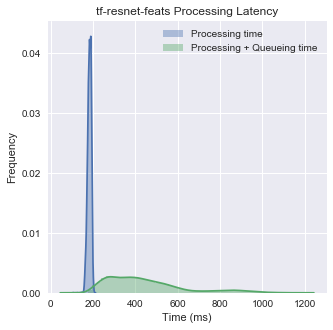

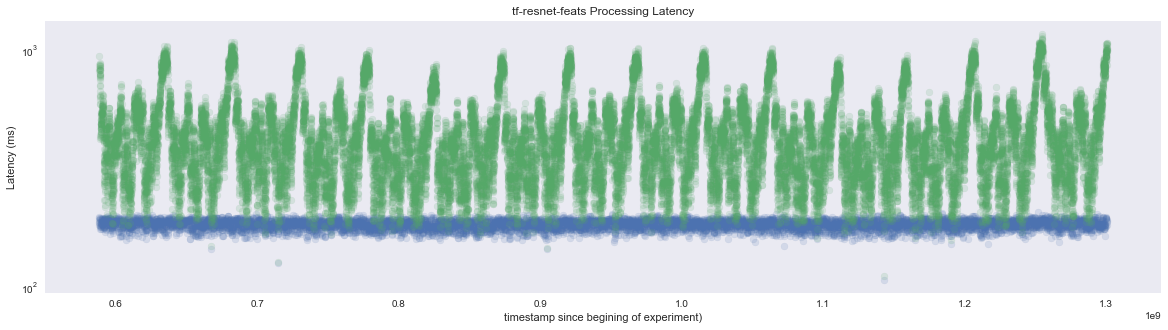

In [652]:
compare_latency_dists(resnet4_exp, resnet_models)
compare_latency_dists_over_time(resnet4_exp, resnet_models)

In [582]:
def get_arrival_intervals(cached_extractions, model):
    arrivals = cached_extractions[model+":1:queue_arrivals"][:,1]
    timestamps = cached_extractions[model+":1:queue_arrivals"][:,0]
    timestamps = timestamps[1:] # taking the timestamp at arrival
    intervals = arrivals[1:] - arrivals[:-1]
    intervals = intervals/1000 # to ms
    return intervals, timestamps
    
def get_outs_intervals(cached_extractions, model):
    outs = cached_extractions[model+":1:processing_outs"][:,1]
    timestamps = cached_extractions[model+":1:processing_outs"][:,0]
    timestamps = timestamps[1:] # taking the timestamp at arrival
    intervals = outs[1:] - outs[:-1]
    intervals = intervals/1000 # to ms
    return intervals, timestamps

def plot_inter_arrival(cached_extractions, model_list):
    plt.figure(figsize=(8,8))
    plt.title("Inter-arrival time")
    plt.xlabel("Inter-arrival time (ms)")
    plt.ylabel("Frequency")
    for model in model_list:
        arrival_intervals, _ = get_arrival_intervals(cached_extractions, model)
        outs_intervals, _ = get_outs_intervals(cached_extractions, model)
        arrival_CV = np.square(np.std(arrival_intervals)/np.mean(arrival_intervals))
        outs_CV = np.square(np.std(outs_intervals)/np.mean(outs_intervals))
        plt.axvline(x=np.mean(arrival_intervals), color="blue")
        plt.axvline(x=np.mean(outs_intervals), color="orange")
        smoothLineHistogram(arrival_intervals, label=model+str(" arrival CV="+str(arrival_CV)))
        smoothLineHistogram(outs_intervals, label=model+str(" outs CV="+str(outs_CV)))
    plt.legend()
    plt.show()

def plot_inter_arrival_over_time(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        arrival_intervals, arrival_timestamps = get_arrival_intervals(cached_extractions, model)
        arrival_CV = np.square(np.std(arrival_intervals)/np.mean(arrival_intervals))
        outs_intervals, outs_timestamps = get_outs_intervals(cached_extractions, model)
        outs_CV = np.square(np.std(outs_intervals)/np.mean(outs_intervals))
        plt.title(model+" Inter-arrival time")
        plt.xlabel("Position")
        plt.ylabel("Inter-arrival time (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([min(np.min(arrival_intervals),np.min(outs_intervals)), max(np.max(arrival_intervals),np.max(outs_intervals))])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        print len(arrival_intervals), len(outs_intervals)
        plt.scatter(arrival_timestamps, arrival_intervals, label="arrival CV="+str(arrival_CV), alpha = 0.3)
        plt.scatter(outs_timestamps, outs_intervals, label="outs CV="+str(outs_CV), alpha = 0.3)
        plt.axhline(y=np.mean(arrival_intervals), color="blue", linestyle="--")
        plt.axhline(y=np.mean(outs_intervals), color="orange", linestyle="--")
        plt.legend()
    plt.show()


29925 22580


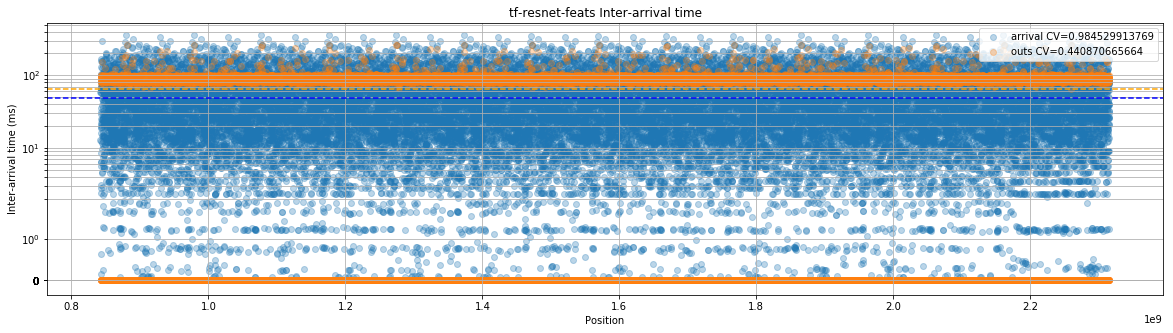

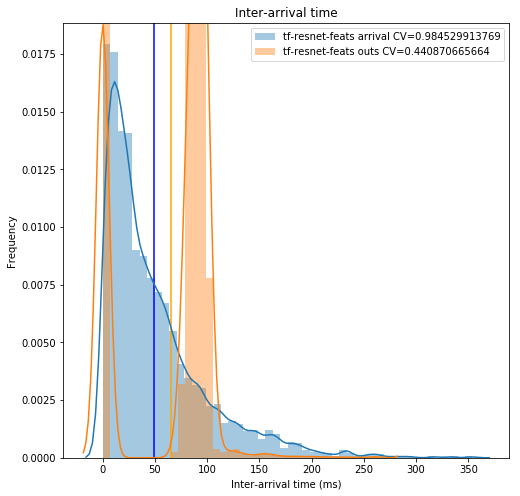

In [583]:
plot_inter_arrival_over_time(resnet4_exp_undersaturated, resnet_models)
plot_inter_arrival(resnet4_exp_undersaturated, resnet_models)

In [563]:
def arrival_curve_and_out_data(cached_extractions, model, trial_range, driver=None):
    if driver == None:
        arrival_timestamps = cached_extractions[model+":1:queue_arrivals"][:,0]
        outs_timestamps = cached_extractions[model+":1:processing_outs"][:,0]
    else:
        arrival_timestamps = driver["driver_sends"]
        outs_timestamps = driver["driver_receives"]
    print len(arrival_timestamps), len(outs_timestamps)
    def get_smallest_delta_1(k, timestamps):
        current_delta = timestamps[k-1] - timestamps[0]
        min_so_far = current_delta
        best_index = k-1
        for index in xrange(k - 1, len(timestamps)-1):
            delta_in = timestamps[index + 1] - timestamps[index]
            delta_out = timestamps[index-(k-1)+1] - timestamps[index-(k-1)]
            next_delta = current_delta - delta_out + delta_in
            if next_delta < min_so_far:
                best_index = index
                min_so_far = next_delta
            current_delta = next_delta
        return min_so_far
    def get_smallest_delta_2(time_range, timestamps):
        head_index = 0 # the first index less than or equal to time_range's higher end
        tail_index = 0 # the first index less than or equal to time_range's lower end
        position = 'tail' # start when time_range's lower end (tail) is aligned with a point
        contained_currently = 1 # a single point (the first index) must be contained in the time_range
        # add the rest of the timepoints contained in time_range
        for i in xrange(tail_index+1, len(timestamps)):
            if timestamps[i] <= timestamps[tail_index] + time_range:
                contained_currently+=1
                head_index+=1
            else:
                break
        max_so_far = contained_currently
        while head_index < len(timestamps)-1: # this means time_range's higher end hasn't exceeded the very last timestamp
            if position == "tail":
                head_time_position = timestamps[tail_index] + time_range
                head_delta = timestamps[head_index+1] - head_time_position
                assert head_delta >= 0
                tail_delta = timestamps[tail_index+1] - timestamps[tail_index]
            elif position == "head":
                tail_time_position = timestamps[head_index] - time_range
                tail_delta = timestamps[tail_index+1] - tail_time_position
                assert tail_delta >= 0
                head_delta = timestamps[head_index+1] - timestamps[head_index]
            if tail_delta < head_delta:
                position = "tail"
                tail_index = tail_index + 1 # head_index stays the same
                contained_currently-=1
            elif head_delta <= tail_delta:
                position = "head"
                head_index = head_index + 1 # tail_index stays the same
                contained_currently+=1
            assert contained_currently >= head_index-tail_index
#             print tail_index, head_index, position, contained_currently, max_so_far
            if contained_currently > max_so_far:
                max_so_far = contained_currently
        return max_so_far
#     arrival_x_axis = np.asarray([get_smallest_delta_1(i, arrival_timestamps) for i in trial_range])
#     arrival_y_axis = trial_range
#     outs_x_axis = np.asarray([get_smallest_delta_1(i, outs_timestamps) for i in trial_range])
#     outs_y_axis = trial_range
    arrival_y_axis = np.asarray([get_smallest_delta_2(i*1000., arrival_timestamps) for i in trial_range])
    arrival_x_axis = np.asarray(list(trial_range)) # converting to ms
    outs_y_axis = np.asarray([get_smallest_delta_2(i*1000., outs_timestamps) for i in trial_range])
    outs_x_axis = np.asarray(list(trial_range)) # converting to ms
    return arrival_x_axis, arrival_y_axis, outs_x_axis, outs_y_axis

def plot_arrival_and_out_curves(cached_extractions, model_list, N=xrange(1,50+1), driver=None):
    plt.figure(figsize=(8,8))
    plt.title("Arrival/service curves")
    plt.xlabel("time-delta in ms")
    plt.ylabel("Queries")
    import itertools
    colors = itertools.cycle(('blue', 'orange', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'grey'))
    for model in model_list:
        arrival_x_data, arrival_y_data, outs_x_data, outs_y_data = arrival_curve_and_out_data(cached_extractions, model, N, driver=driver)
        color = colors.next()
        plt.plot(arrival_x_data, arrival_y_data, color = "blue", linestyle="--", label=model+" arrival curve")
        plt.plot(outs_x_data, outs_y_data, color = "blue", label=model+" service curve")
    plt.legend()
#     y_jump = 1
#     max_N = max(N)
#     while max_N/y_jump > 30:
#         y_jump*=2
#     plt.yticks(np.arange(0, max_N+1, y_jump))
    plt.grid(True)
    plt.show()

40000 39999


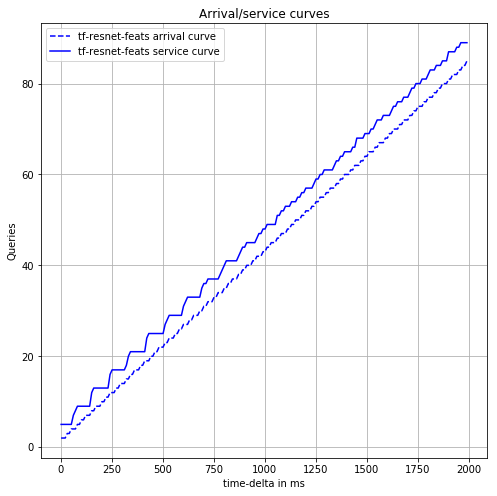

In [568]:
plot_arrival_and_out_curves(resnet4, resnet_models, N=xrange(1,2000,10), driver=resnet_hollistic4)

40000 39998


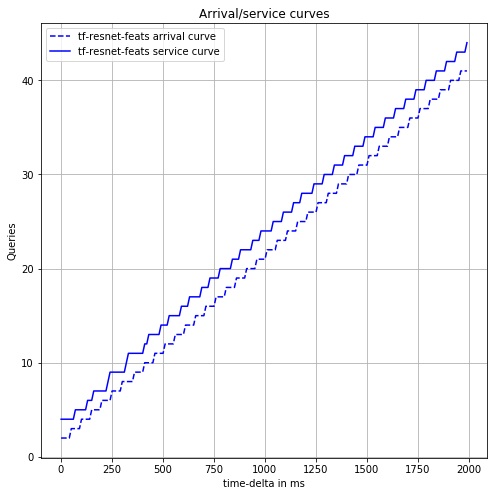

In [567]:
plot_arrival_and_out_curves(resnet4_undersaturated, resnet_models, N=xrange(1,2000,10), driver=resnet_hollistic4_undersaturated)

40000 39999


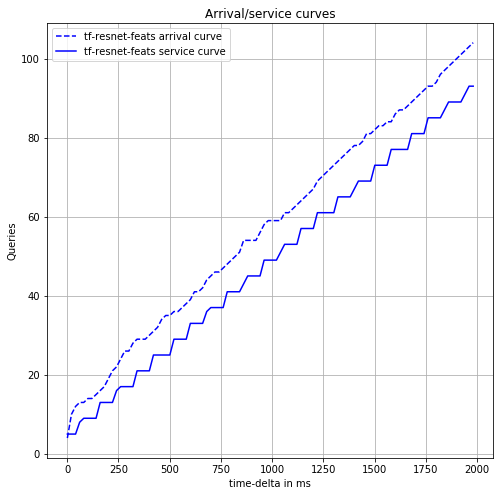

In [566]:
plot_arrival_and_out_curves(resnet4_exp, resnet_models, N=xrange(1,2000,10), driver=resnet_hollistic4_exp)

In [36]:
def plot_queue_sizes(cached_extractions, model_list, log=False):
    plt.figure(figsize=(8,8))
    plt.title("Queue length")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    if log:
        plt.xscale("log")
    for model in model_list:
        sizes = cached_extractions[model+":1:queue_sizes"]
        plt.hist(sizes, label=model,alpha=0.3)
    plt.legend()
    
def plot_ordinal_queue_sizes(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        sizes = cached_extractions[model+":1:queue_sizes"][:,1]
        timestamps = cached_extractions[model+":1:queue_sizes"][:,0]
        plt.title(model+" Queue length")
        plt.xlabel("Position")
        plt.ylabel("Length")
        needlog = np.max(sizes) - np.min(sizes) > 10
        bounds = np.asarray([np.min(sizes), np.max(sizes)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, sizes, label=model, alpha = 0.3)

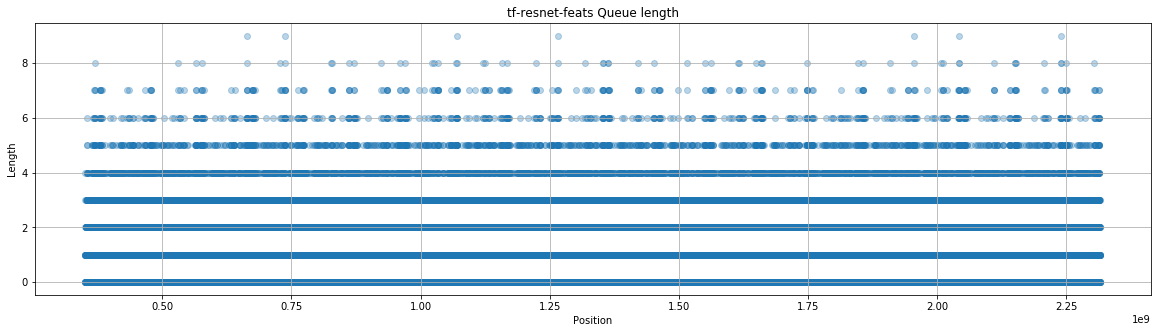

In [574]:
plot_ordinal_queue_sizes(resnet4_exp_undersaturated, resnet_models)

In [517]:
def plot_e2e_lats(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("e2e Latencies")
    lats = cached_extractions["e2e_lats"]
    plt.plot(np.arange(len(lats)), lats)
    plt.xlabel("Experiment iteration")
    plt.axhline(y=0.5, color='r', linestyle='--', label="500ms SLO")
    plt.legend()
    plt.ylabel("Latency (ms)")

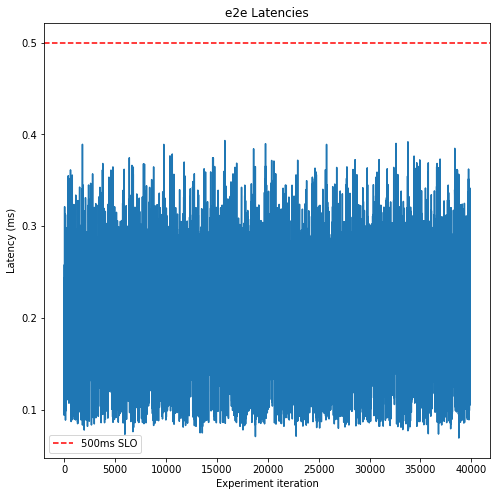

In [573]:
plot_e2e_lats(resnet_hollistic4_exp_undersaturated)

In [519]:
def plot_e2e_thrus(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("e2e Throughputs")
    thrus = cached_extractions["e2e_thrus"]
    plt.scatter(np.arange(len(thrus)), thrus)
    plt.xlabel("Experiment iteration")
    plt.ylabel("Throughput (queries per second)")
    label = cached_extractions["used_delay_process"] + cached_extractions["used_delay_batchsize"]
    plt.axhline(y=1/float(cached_extractions["used_delay_value"]), color="red", linestyle='--', label=label)
    plt.grid(True)
    plt.legend()

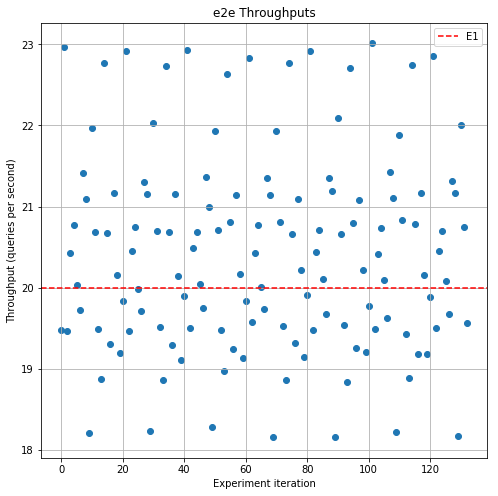

In [572]:
plot_e2e_thrus(resnet_hollistic4_exp_undersaturated)

In [489]:
def plot_mean_effective_batchsizes(cached_extraction):
    plt.figure(figsize=(8,8))
    plt.title("Mean effective batchsizes")
    batchsizes = cached_extraction["mean_batch_sizes"]
    for key in batchsizes.keys():
        plt.scatter(np.arange(len(batchsizes[key])), batchsizes[key], label=key)
    plt.xlabel("Experiment iteration")
    plt.ylabel("Mean effective batchsize")
    plt.legend()
    plt.grid(True)


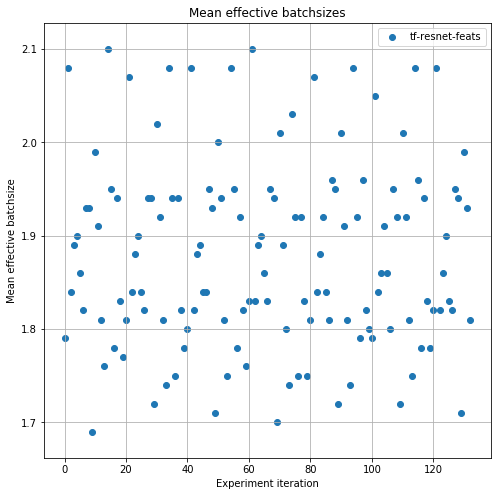

In [571]:
plot_mean_effective_batchsizes(resnet_hollistic4_exp_undersaturated)

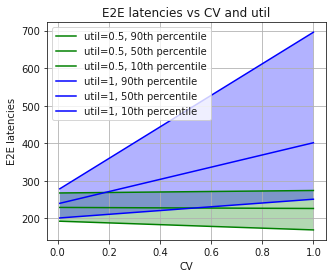

In [686]:
import seaborn as sns
import pandas as pd
c1 = resnet_hollistic4["e2e_lats"]*1000.
e1 = resnet_hollistic4_exp["e2e_lats"]*1000.
c05 = resnet_hollistic4_undersaturated["e2e_lats"]*1000.
e05 = resnet_hollistic4_exp_undersaturated["e2e_lats"]*1000.

prev = None
for p in [(90), (50), (10)]:
    x = [0.008, 1.0]
    current = [np.percentile(c05,p), np.percentile(e05,p)]
    plt.plot(x, current, color = "green", label=("util=0.5, {}th percentile").format(p))
    if prev != None:
        plt.gca().fill_between(x, prev, current, where=current<=prev, facecolor='green', alpha=0.3, interpolate=True)
    prev = current

prev = None
for p in [(90), (50), (10)]:
    x = [0.008, 1.0]
    current = [np.percentile(c1,p), np.percentile(e1,p)]
    plt.plot(x, current, color = "blue", label=("util=1, {}th percentile").format(p))
    if prev != None:
        plt.gca().fill_between(x, prev, current, where=current<=prev, facecolor='blue', alpha=0.3, interpolate=True)
    prev = current
    
plt.grid(True)
plt.title("E2E latencies vs CV and util")
plt.xlabel("CV")
plt.ylabel("E2E latencies")
plt.legend()
plt.show()